In [1]:
# This notebook extracts daily SST time-series from the ESA-CCI L4 analysis dataset v2.1 available here
# https://data.ceda.ac.uk/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1
# The time series are extracted on an area that is 0.2 deg wide.
# Daily data are converted to monthly data and then some temporal stats are computed.

# From the daily data I can compute a single annual file with the monthly means with
#     cdo -monmean -cat '2010*nc' monthly_2010.nc
# NB: I recursively link the daily files in the same (annual) folder with 
#     ln -r -s */*/*1-v* . 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob

In [3]:
def plot_background(ax):
    #ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [4]:
# Read the file with the location of the sediments

filename = 'DB_27122022.csv'
df_loc = pd.read_csv(filename,sep='\t')
df_loc

,LAT,LONG,Water depth,Stations/Facies
0,-16.50,-151.80,10.0,BB14
1,-16.50,-151.80,0.5,BB19
2,-16.50,-151.80,3.0,BB28
3,-16.50,-151.80,13.0,BB1
4,-16.50,-151.80,22.0,BB2
...,...,...,...,...
2259,-26.07,32.95,2.5,T6Pontatorres_3
2260,-26.07,32.95,5.0,T6Pontatorres_4
2261,-26.07,32.95,6.5,T6Pontatorres_5
2262,-26.07,32.95,7.0,T6Pontatorres_6


In [5]:
# Set the path to SST files
path2sst = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/'
#path2chla

# Set the time window in which data are available at the monthly res.
str_start = '2007-01-01' #'YYYY-MM-DD'
str_end = '2013-12-01'
instant_start = np.datetime64(str_start)
instant_end = np.datetime64(str_end)

# Set the half width of the box over which to take the average.
dlat = 0.1
dlon = 0.1

In [90]:
allstats_db = np.array(['LONG','LAT','Water depth','Stations/Facies','SSTmin_K','SSTavg_K','SSTmax_K','SSTJan_K','SSTFeb_K','SSTMar_K','SSTApr_K','SSTMay_K','SSTJun_K',
              'SSTJul_K','SSTAug_K','SSTSep_K','SSTOct_K','SSTNov_K','SSTDec_K'])

for ss in range(15): # range(len(df_loc['LONG'])) # Loop on the sites.
    # Select the point.
    lon0 = df_loc['LONG'][ss]
    lat0 = df_loc['LAT'][ss]
    wd0 = df_loc['Water depth'][ss]
    sf0 = df_loc['Stations/Facies'][ss]
    
    print('--------------------------------------------')
    print(sf0 + ' at ' + str(wd0) +' m')
    print('--------------------------------------------')

    # Time loop
    instant = instant_start
    it_s_the_first_instant = True
    sst_series = []
    time_series = []
    sst_seasonal = np.zeros(12) # To compute the seasonal cycle
    sst_seasonal_count = np.zeros(12)

    while instant <= instant_end:
        print(instant)
        pd_instant = pd.to_datetime(instant)
        year_oi = str(pd_instant.year).zfill(4)
        month_oi = str(pd_instant.month).zfill(2)
        day_oi = str(pd_instant.day).zfill(2)

        # Set the path to the SST data.
        path_sst_oi = path2sst + '/' +  year_oi + '/'
        filename_sst = 'monthly_'+year_oi+'.nc'
        ds_sst = xr.open_dataset(path_sst_oi + filename_sst)

        for mm in range(12):
            #print(mm+1)
            sst0 = ds_sst['analysed_sst'][mm].sel(lon=slice(lon0-dlon,lon0+dlon),
                                                  lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

            sst_series.extend([sst0.item()])
            sst_seasonal[mm] += sst0
            sst_seasonal_count[mm] += 1
            #print(sst_series)
            time_series.extend([year_oi + '-' + str(mm+1).zfill(2)])

            if it_s_the_first_instant:
                # Check the position of the point on a map.
                crs = ccrs.PlateCarree()
                lon_sst = ds_sst['lon'].values
                lat_sst = ds_sst['lat'].values
                l4_sst = ds_sst['analysed_sst'].values

                it_s_the_first_instant = False


        instant = np.datetime64(str(int(year_oi)+1)+'-01-01') #+= np.timedelta64(1,'Y')

    sst_t = np.array(sst_series)
    
    sst_stats = np.concatenate((np.array([lon0,lat0,wd0,sf0,sst_min, sst_avg, sst_max]),sst_seasonal_cycle))
    allstats_db = np.vstack([allstats_db,sst_stats])
    
    print(allstats_db)
    
pd.DataFrame(allstats_db).to_csv('stats_prova.csv')


--------------------------------------------
BB14 at 10.0 m
--------------------------------------------
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
[['LONG' 'LAT' 'Water depth' 'Stations/Facies' 'SSTmin_K' 'SSTavg_K'
  'SSTmax_K' 'SSTJan_K' 'SSTFeb_K' 'SSTMar_K' 'SSTApr_K' 'SSTMay_K'
  'SSTJun_K' 'SSTJul_K' 'SSTAug_K' 'SSTSep_K' 'SSTOct_K' 'SSTNov_K'
  'SSTDec_K']
 ['-151.8' '-16.5' '10.0' 'BB14' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']]
--------------------------------------------
BB19 at 0.5 m
--------------------------------------------
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
[['LONG' 'LAT' 'Water depth' 'Stations/Facies' 'SSTmin_K' 'SSTavg

2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
[['LONG' 'LAT' 'Water depth' 'Stations/Facies' 'SSTmin_K' 'SSTavg_K'
  'SSTmax_K' 'SSTJan_K' 'SSTFeb_K' 'SSTMar_K' 'SSTApr_K' 'SSTMay_K'
  'SSTJun_K' 'SSTJul_K' 'SSTAug_K' 'SSTSep_K' 'SSTOct_K' 'SSTNov_K'
  'SSTDec_K']
 ['-151.8' '-16.5' '10.0' 'BB14' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']
 ['-151.8' '-16.5' '0.5' 'BB19' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']
 ['-151.8' '

2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
[['LONG' 'LAT' 'Water depth' 'Stations/Facies' 'SSTmin_K' 'SSTavg_K'
  'SSTmax_K' 'SSTJan_K' 'SSTFeb_K' 'SSTMar_K' 'SSTApr_K' 'SSTMay_K'
  'SSTJun_K' 'SSTJul_K' 'SSTAug_K' 'SSTSep_K' 'SSTOct_K' 'SSTNov_K'
  'SSTDec_K']
 ['-151.8' '-16.5' '10.0' 'BB14' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']
 ['-151.8' '-16.5' '0.5' 'BB19' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']
 ['-151.8' '

2013-01-01
[['LONG' 'LAT' 'Water depth' 'Stations/Facies' 'SSTmin_K' 'SSTavg_K'
  'SSTmax_K' 'SSTJan_K' 'SSTFeb_K' 'SSTMar_K' 'SSTApr_K' 'SSTMay_K'
  'SSTJun_K' 'SSTJul_K' 'SSTAug_K' 'SSTSep_K' 'SSTOct_K' 'SSTNov_K'
  'SSTDec_K']
 ['-151.8' '-16.5' '10.0' 'BB14' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']
 ['-151.8' '-16.5' '0.5' 'BB19' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']
 ['-151.8' '-16.5' '3.0' 'BB28' '299.36602783203125' '301.075441269

2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
[['LONG' 'LAT' 'Water depth' 'Stations/Facies' 'SSTmin_K' 'SSTavg_K'
  'SSTmax_K' 'SSTJan_K' 'SSTFeb_K' 'SSTMar_K' 'SSTApr_K' 'SSTMay_K'
  'SSTJun_K' 'SSTJul_K' 'SSTAug_K' 'SSTSep_K' 'SSTOct_K' 'SSTNov_K'
  'SSTDec_K']
 ['-151.8' '-16.5' '10.0' 'BB14' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']
 ['-151.8' '-16.5' '0.5' 'BB19' '299.36602783203125' '301.0754412696475'
  '302.7432861328125' '301.62455095563615' '301.80752999441967'
  '301.92332676478793' '302.0980878557478' '301.70896693638394'
  '301.04085867745533' '300.37351771763394' '299.8985682896205'
  '299.8533194405692' '300.1375296456473' '300.91466849190846'
  '301.5243704659598']
 ['-151.8' '

In [39]:

# Select the point.
lon0 = df_loc['LONG'][0]
lat0 = df_loc['LAT'][0]
wd0 = df_loc['Water depth'][0]
sf0 = df_loc['Stations/Facies'][0]

# Time loop
instant_start = np.datetime64(str_start)
instant_end = np.datetime64(str_end)
instant = instant_start
it_s_the_first_instant = True
sst_series = []
time_series = []
sst_seasonal = np.zeros(12) # To compute the seasonal cycle
sst_seasonal_count = np.zeros(12)

while instant <= instant_end:
    print(instant)
    pd_instant = pd.to_datetime(instant)
    year_oi = str(pd_instant.year).zfill(4)
    month_oi = str(pd_instant.month).zfill(2)
    day_oi = str(pd_instant.day).zfill(2)

    # Set the path to the SST data.
    path_sst_oi = path2sst + '/' +  year_oi + '/'
    filename_sst = 'monthly_'+year_oi+'.nc'
    ds_sst = xr.open_dataset(path_sst_oi + filename_sst)

    for mm in range(12):
        print(mm+1)
        sst0 = ds_sst['analysed_sst'][mm].sel(lon=slice(lon0-dlon,lon0+dlon),
                                              lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

        sst_series.extend([sst0.item()])
        sst_seasonal[mm] += sst0
        sst_seasonal_count[mm] += 1
        print(sst_seasonal_count)
        #print(sst_series)
        time_series.extend([year_oi + '-' + str(mm+1).zfill(2)])

        if it_s_the_first_instant:
            # Check the position of the point on a map.
            crs = ccrs.PlateCarree()
            lon_sst = ds_sst['lon'].values
            lat_sst = ds_sst['lat'].values
            l4_sst = ds_sst['analysed_sst'].values

            it_s_the_first_instant = False
    
        
    instant = np.datetime64(str(int(year_oi)+1)+'-01-01') #+= np.timedelta64(1,'Y')

sst_t = np.array(sst_series)

2007-01-01
1
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
5
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
6
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
7
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
9
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
10
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
11
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
12
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2008-01-01
1
[2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2
[2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
3
[2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
4
[2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
5
[2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1.]
6
[2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1.]
7
[2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1.]
8
[2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
9
[2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.]
10
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1.]
11
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
12
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
2009-01-01
1

In [72]:
a = np.array([1,1,1])
b = np.array([2,2,2])

c = np.append([a],[b],axis=0)
c

array([[1, 1, 1],
       [2, 2, 2]])

In [40]:
# Compute the relevant stats

sst_min = np.min(sst_t)
sst_max = np.max(sst_t)
sst_avg = np.mean(sst_t)

sst_seasonal_cycle = sst_seasonal/sst_seasonal_count 

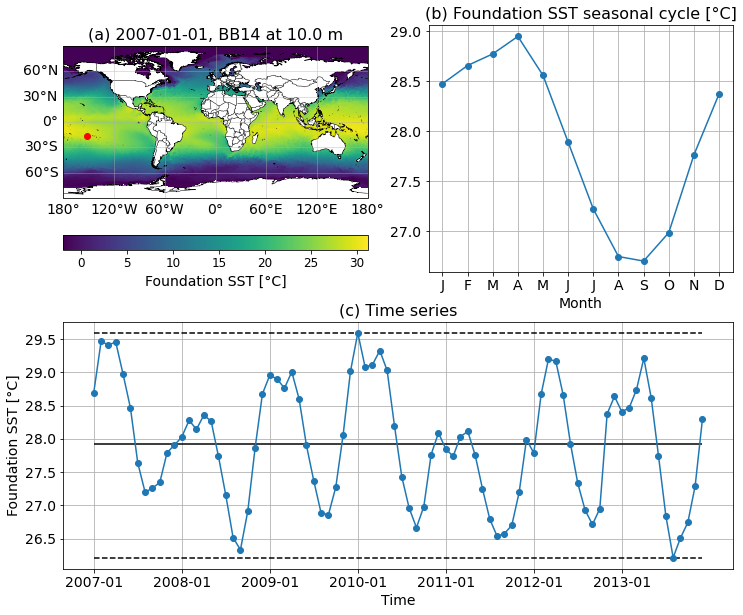

In [51]:
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1,projection=crs)
plot_background(ax1)
pc1 = ax1.pcolormesh(lon_sst,lat_sst,l4_sst[0]-273.15,shading='nearest',transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(pc1, orientation = 'horizontal')
cbar1.ax.tick_params(labelsize=12) 
ax1.plot(lon0,lat0,'or')
ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
         [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
cbar1.set_label('Foundation SST [°C]',size=14)
ax1.set_title('(a) ' + str_start+', '+sf0+' at '+str(wd0)+' m', fontsize=16)

ax2 = fig.add_subplot(2,2,2)
ax2.plot(np.arange(1,13),sst_seasonal_cycle-273.15,'o-')
ax2.tick_params(axis='both',labelsize=14)
ax2.set_title('(b) Foundation SST seasonal cycle [°C]', fontsize=16)
ax2.set_xlabel('Month',fontsize=14)
ax2.set_xticks(np.arange(1,13))
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.grid()

ax3 = fig.add_subplot(2,1,2)
ax3.plot(time_series,sst_t-273.15,'o-')
ax3.tick_params(axis='both',labelsize=14)
ax3.set_ylabel('Foundation SST [°C]',fontsize=14)
ax3.set_xlabel('Time',fontsize=14)
ax3.set_xticks(np.arange(0,len(sst_series),12))
ax3.set_xticklabels(time_series[::12])
ax3.set_title('(c) Time series', fontsize=16)
plt.grid()
ax3.hlines(sst_max-273.15,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(sst_min-273.15,time_series[0],time_series[-1],colors='k',linestyles='dashed')
ax3.hlines(sst_avg-273.15,time_series[0],time_series[-1],colors='k',linestyles='solid')

figure_name = 'map_time_series_sst_'+sf0+'_'+str(wd0)+'.png'
plt.savefig(figure_name,bbox_inches='tight')

In [59]:
# Set the path to SST files
path2sst = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/'
#path2chla

# Set the time window in which data are available
str_start = '2010-12-01' #'YYYY-MM-DD'
str_end = '2010-12-31'

In [24]:
# Set the half width of the box over which to take the average.
dlat = 0.1
dlon = 0.1

# Select the point.
lon0 = df_loc['LONG'][0]
lat0 = df_loc['LAT'][0]

# Time loop
instant_start = np.datetime64(str_start)
instant_end = np.datetime64(str_end)
instant = instant_start
it_s_the_first_instant = True
sst_series = []

while instant <= instant_end:
    print(instant)
    pd_instant = pd.to_datetime(instant)
    year_oi = str(pd_instant.year).zfill(4)
    month_oi = str(pd_instant.month).zfill(2)
    day_oi = str(pd_instant.day).zfill(2)

    # Set the path to the SST data. For a given day, read the L4 daily map over the area of interest.
    path_sst_oi = path2sst + '/' +  year_oi + '/' + month_oi + '/' + day_oi + '/'
    filename_sst = sorted(glob(path_sst_oi + '*2.1-v*')) # this removes the file with the 'anomaly' in their name.
    ds_sst = xr.open_dataset(filename_sst[0])

    sst0 = ds_sst['analysed_sst'].sel(lon=slice(lon0-dlon,lon0+dlon),
                                      lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

    if it_s_the_first_instant:
        # Check the position of the point on a map.
        crs = ccrs.PlateCarree()
        lon_sst = ds_sst['lon'].values
        lat_sst = ds_sst['lat'].values
        l4_sst = ds_sst['analysed_sst'].values
        
        fig = plt.figure(figsize=(20,14))

        ax1 = fig.add_subplot(2, 1, 1, projection=crs)
        plot_background(ax1)
        pc1 = ax1.pcolormesh(lon_sst,lat_sst,l4_sst[0]-273.15,shading='nearest',transform=ccrs.PlateCarree())
        cbar1 = plt.colorbar(pc1)
        cbar1.ax.tick_params(labelsize=12) 
        ax1.plot(lon0,lat0,'or')
        ax1.plot([lon0-dlon,lon0+dlon,lon0+dlon,lon0-dlon,lon0-dlon],
                 [lat0-dlat,lat0-dlat,lat0+dlat,lat0+dlat,lat0-dlat],'red')
        cbar1.set_label('Depth SST [°C]',size=14)
        ax1.set_title(year_oi + '-' + month_oi + '-' + day_oi, fontsize=16)
        
        it_s_the_first_instant = False
    
    print(sst0)
    print(sst0.dtype)
    sst_series.extend(sst0)
    instant += np.timedelta64(1,'D')
        

2007-01-01
[302.252]
float32
2007-01-02
[302.15134]
float32
2007-01-03
[302.158]
float32
2007-01-04
[302.16534]
float32
2007-01-05
[302.23065]
float32
2007-01-06
[302.21]
float32
2007-01-07
[302.1733]
float32
2007-01-08
[302.128]
float32
2007-01-09
[302.16064]
float32
2007-01-10
[302.24265]
float32
2007-01-11
[302.17596]
float32
2007-01-12
[302.06198]
float32
2007-01-13
[302.07468]
float32
2007-01-14
[301.8033]
float32
2007-01-15
[301.7547]
float32
2007-01-16
[301.62534]
float32
2007-01-17
[301.49734]
float32
2007-01-18
[301.45203]
float32
2007-01-19
[301.52597]
float32
2007-01-20
[301.53333]
float32
2007-01-21
[301.622]
float32
2007-01-22
[301.59402]
float32
2007-01-23
[301.46335]
float32
2007-01-24
[301.52597]
float32
2007-01-25
[301.45]
float32
2007-01-26
[301.53333]
float32
2007-01-27
[301.764]
float32
2007-01-28
[301.68536]
float32
2007-01-29
[301.68997]
float32
2007-01-30
[301.67932]
float32
2007-01-31
[301.86465]
float32
2007-02-01
[301.87735]
float32
2007-02-02
[301.86133]
floa

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f3b4c1643a0> (for post_execute):


KeyboardInterrupt: 

302.7444


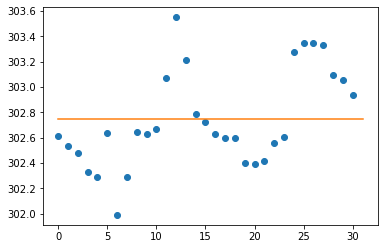

In [50]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# JAN

302.23093


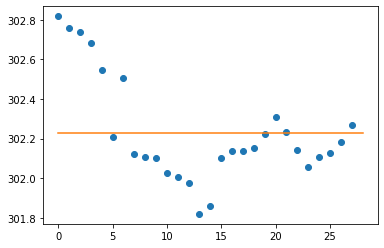

In [58]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# FEB

301.2399


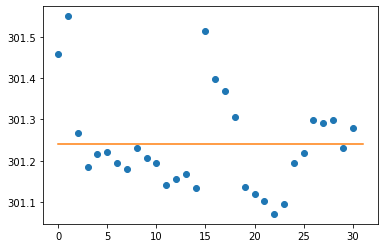

In [61]:
plt.plot(sst_series,'o')
plt.plot([0,len(sst_series)],np.array([1,1])*np.mean(sst_series))
print(np.mean(sst_series))
# DEC

In [54]:
monthly_file = '/media/agostino/sailboat/neodc/esacci/sst/data/CDR_v2/Analysis/L4/v2.1/2010/prova.nc'
ds_m = xr.open_dataset(monthly_file)
sst0 = ds_m['analysed_sst'].sel(lon=slice(lon0-dlon,lon0+dlon),
                                lat=slice(lat0-dlat,lat0+dlat)).mean(dim=['lon','lat'],skipna=True).values

print(sst0)

[302.7433  302.23    302.26602 302.47733 302.18002 301.3493  300.58066
 300.11133 299.81732 300.1327  300.9153  301.23996]
